In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
import re

In [5]:
##################################################
####### import function 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


## Figure S79

File Montmorillonite_below25um_isotherm_27C-2023-10-10 14-05-16.xls read succesfull
File Montmorillonite_50-100um_isotherm_27C-2023-10-10 14-05-16.xls read succesfull
File Montmorillonite_isotherm_27C_TGApan-2022-10-04 14-48-28.xls read succesfull
[]
[0, 46153]
0 46153
[]
[0, 46153]
0 46153
[]
[0, 43212]
0 43212


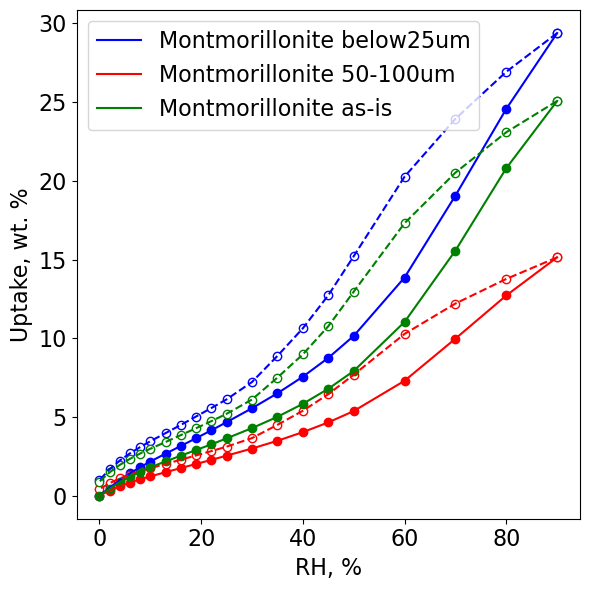

In [6]:
text_size = 16

#################################
###    import Sorption data   ###
#################################

path = '../../../../data/water_sorption/DVS/isotherms/different_fractions/'

filelist = ['Montmorillonite_below25um_isotherm_27C-2023-10-10 14-05-16.xls',
            'Montmorillonite_50-100um_isotherm_27C-2023-10-10 14-05-16.xls',
            'Montmorillonite_isotherm_27C_TGApan-2022-10-04 14-48-28.xls'
           
           ]

# color list
name_and_color_dictionary = {'Montmorillonite_below25um_isotherm_27C-2023-10-10 14-05-16.xls':{'color':'b', 'name':'Montmorillonite below25um'},
                             'Montmorillonite_50-100um_isotherm_27C-2023-10-10 14-05-16.xls':{'color':'r', 'name':'Montmorillonite 50-100um'},
                             'Montmorillonite_isotherm_27C_TGApan-2022-10-04 14-48-28.xls':{'color':'g', 'name':'Montmorillonite as-is'},
                            }

Sorption_list = []
Water_Sorption_list = []
for Sorption_filename in filelist:
    Sorption = file_Sorption()
    try:
        Sorption.read_file(path,Sorption_filename)
        if Sorption.import_success:
            if Sorption.fluid == 'water vapor':
                Water_Sorption_list.append(Sorption)
            else:
                Sorption_list.append(Sorption)
            #print(Sorption.instrument)
        else:
            del Sorption
            print(Sorption_filename, 'failed')
    except Exception as e:
        print(e)
        print(Sorption_filename, 'failed')
        
fig, ax = plt.subplots(1, 1, figsize=(6,6))



#################################
###    plot isotherms         ###
#################################        

for m, Sorption in enumerate(Water_Sorption_list):
    Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
    split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
    split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()

    index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
    index_tuple = sorted(index_tuple, key=lambda x: x[1])
    #print(index_tuple)
    isotherm_split = []
    prev = 'ads'
    for i, j in enumerate([i[0] for i in index_tuple]):
        if (j == 'ads')&(prev=='des'):
            isotherm_split.append(index_tuple[i][1])
        prev = j
    print(isotherm_split)
    args = [0]+isotherm_split+[Sorption.data.index.size]
    #args= args[:2]
    print(args)

    for start,  end in zip(args, args[1:]):
        print(start,  end)
        split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()

        split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
        split_index_ads = split_index_ads + [split_index_des[0]]

        #print(split_index_ads)
        #print(split_index_des)
        isotherm_RHtarget_ads = []
        isotherm_RHactual_ads = []
        isotherm_adsorption = []
        isotherm_RHtarget_des = []
        isotherm_RHactual_des = []
        isotherm_desorption = []
        for i, split in enumerate(split_index_ads[:]):
            isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
            if i==0:
                isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
            else:
                isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
        for i, split in enumerate(split_index_des[:]):
            isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
            if i == 0:
                isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
            else:
                isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
        ax.plot(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],  
                 c=name_and_color_dictionary[Sorption.filename]['color'],
                 label=name_and_color_dictionary[Sorption.filename]['name'])
        ax.scatter(isotherm_RHtarget_ads, [i for i in isotherm_adsorption],     
                        c=name_and_color_dictionary[Sorption.filename]['color'],
                       )
        ax.plot(isotherm_RHtarget_des, [i for i in isotherm_desorption],
                     c=name_and_color_dictionary[Sorption.filename]['color'], linestyle='dashed')
        ax.scatter(isotherm_RHtarget_des, [i for i in isotherm_desorption],  
                        facecolors='w', edgecolors=name_and_color_dictionary[Sorption.filename]['color'],
                       )
        ax.set_xlabel('RH, %', fontsize=text_size)
        ax.set_ylabel('Uptake, wt. %', fontsize=text_size)
        ax.tick_params(axis='x', labelsize=text_size)
        ax.tick_params(axis='y', labelsize=text_size)
        
        #ax[0, m].set_xlim([0, 30])
        ax.legend(fontsize=text_size)
        #x[0, m].set_title('File: '+Sorption.filename)
fig.tight_layout()
plt.savefig('Montmorillonite_isotherms.png', dpi=600)
plt.show()